# Convolutional Neural Net for CIFAR-10 data

We will construct a variety of CNN's to predict the class of image present in the baseline [CIFAR-10](http://www.cs.utoronto.ca/~kriz/cifar.html) image data set.  This data set contains 32x32 images across 10 classes.  There are 50000 total training images and 10000 total test images.  Each class is represented by 5000 and 1000 images in each set, respectively.  

In [53]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import skimage
from sklearn.metrics import confusion_matrix

%matplotlib inline

import tensorflow as tf
import keras 
from keras import backend as K

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import RMSprop, SGD, Adadelta
from keras.losses import categorical_crossentropy

import pickle

Getting data out of several pickles.

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        out = pickle.load(fo, encoding='bytes')
    return out

In [3]:
batch_1 = unpickle('../Unit 4/cifar-10-batches-py/data_batch_1')
batch_2 = unpickle('../Unit 4/cifar-10-batches-py/data_batch_2')
batch_3 = unpickle('../Unit 4/cifar-10-batches-py/data_batch_3')
batch_4 = unpickle('../Unit 4/cifar-10-batches-py/data_batch_4')
batch_5 = unpickle('../Unit 4/cifar-10-batches-py/data_batch_5')
batch_test = unpickle('../Unit 4/cifar-10-batches-py/test_batch')

In [4]:
batch_1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [5]:
pd.Series(batch_1[b'labels']).value_counts()

2    1032
6    1030
8    1025
3    1016
0    1005
7    1001
4     999
9     981
1     974
5     937
dtype: int64

In [6]:
batch_1[b'data'].shape

(10000, 3072)

Each batch is randomly populated with classes of images.  While the individual batches are not perfectly balanced, the dataset as a whole is.

**data** -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.

**labels** -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

In [64]:
# From the CIFAR-10 website, we find the label names

label_names = ['Airplane', 
              'Automobile', 
              'Bird', 
              'Cat', 
              'Deer', 
              'Dog', 
              'Frog', 
              'Horse', 
              'Ship', 
              'Truck']

In [7]:
def rgb_combine(batch, img):
    '''Reorganizing, reshaping, and rescaling the image data'''
    red = np.array(batch[b'data'][img][:1024]).reshape(32, 32)
    green = np.array(batch[b'data'][img][1024:2048]).reshape(32, 32)
    blue = np.array(batch[b'data'][img][2048:]).reshape(32, 32)
    out = np.stack([red, green, blue], axis=2)

    # Rescaling
    out = out.astype('float32')
    out /= 255
    
    return out

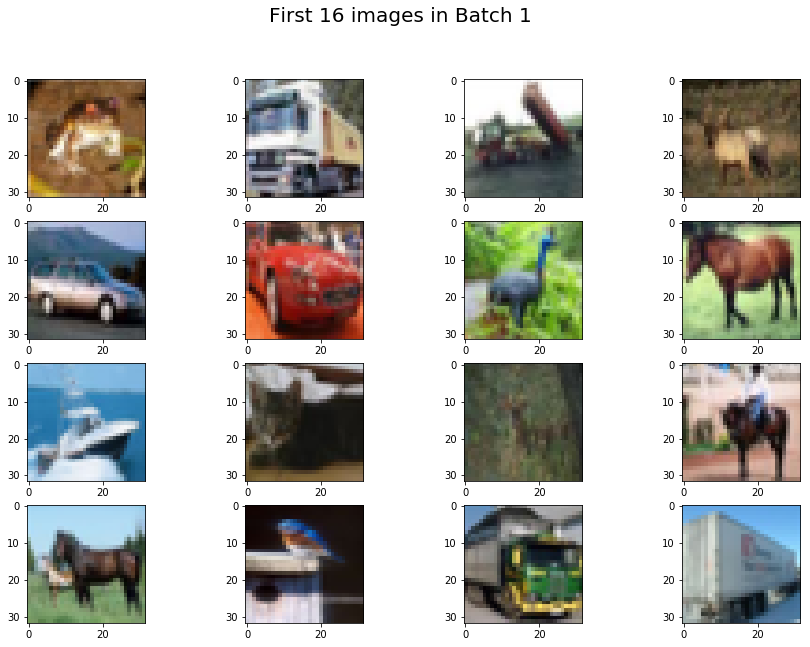

In [8]:
plt.figure(figsize=(15,10))
plt.suptitle('First 16 images in Batch 1', size=20)
for i in range(16):
    plt.subplot(4,4,(i+1))
    plt.imshow(rgb_combine(batch_1, i))
plt.show()

In [9]:
# Looping through all training images in each batch to stack them in the same array

batch_list = [batch_1, batch_2, batch_3, batch_4, batch_5]
train_img = []

for batch in batch_list:
    for i in range(len(batch[b'data'])):
        train_img.append(rgb_combine(batch, i))
train_img = np.stack(train_img)

In [10]:
train_img.shape

(50000, 32, 32, 3)

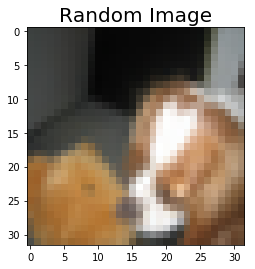

In [11]:
plt.imshow(train_img[3456])
plt.title('Random Image', size=20)
plt.show()

In [12]:
# Getting all the test images

test_img = []
for i in range(len(batch_test[b'data'])):
    test_img.append(rgb_combine(batch_test, i))
test_img = np.stack(test_img)

In [13]:
# Getting the labels for both training and test sets

train_label = []
for batch in batch_list:
    for i in range(len(batch[b'labels'])):
        train_label.append(batch[b'labels'][i])
train_label = np.array(train_label)

test_label = []
for i in range(len(batch_test[b'labels'])):
    test_label.append(batch_test[b'labels'][i])
test_label = np.array(test_label)

In [14]:
print('Training images: ', train_img.shape)
print('Training labels: ', train_label.shape)
print('Test images: ', test_img.shape)
print('Test labels: ', test_label.shape)

Training images:  (50000, 32, 32, 3)
Training labels:  (50000,)
Test images:  (10000, 32, 32, 3)
Test labels:  (10000,)


In [15]:
# Data dimensions
img_rows, img_cols = 32, 32
num_classes = 10
num_channels = 3
input_shape = (img_rows, img_cols, num_channels)

In [16]:
# Label binarization
train_label = keras.utils.to_categorical(train_label, num_classes)
test_label = keras.utils.to_categorical(test_label, num_classes)

## Initial model architecture

We'll use a commonly used architecture of 3 stacked modules (convolution + relu + maxpooling) followed by 2 dense layers.

- Conv2D, depth=16, kernel=(3,3), relu
- MaxPooling2D, pooling=(2,2)
- Conv2D, depth=32, kernel=(3,3), relu
- MaxPooling2D, pooling=(2,2)
- Conv2D, depth=64, kernel=(3,3), relu
- MaxPooling2D, pooling=(2,2)
- Flatten
- Dense, depth=128, relu
- Dense, depth=10, softmax

In [17]:
# Model instantiation
model = Sequential()
model.add(Conv2D(16, kernel_size=(3,3), 
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flat

In [22]:
# Compile and train the initial model. 

model.compile(loss=categorical_crossentropy, 
              optimizer=RMSprop(),
              metrics=['acc'])

history = model.fit(train_img,
                    train_label,
                    batch_size=64,
                    epochs=10, 
                    verbose=1,
                    validation_data=(test_img, test_label))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 17s 335us/step - loss: 0.9545 - acc: 0.6665 - val_loss: 1.0391 - val_acc: 0.6376
Epoch 2/10
50000/50000 [==============================] - 17s 331us/step - loss: 0.8976 - acc: 0.6878 - val_loss: 1.0651 - val_acc: 0.6272
Epoch 3/10
50000/50000 [==============================] - 17s 331us/step - loss: 0.8520 - acc: 0.7032 - val_loss: 0.9991 - val_acc: 0.6570
Epoch 4/10
50000/50000 [==============================] - 16s 316us/step - loss: 0.8099 - acc: 0.7167 - val_loss: 1.0238 - val_acc: 0.6531
Epoch 5/10
50000/50000 [==============================] - 16s 319us/step - loss: 0.7742 - acc: 0.7288 - val_loss: 1.1151 - val_acc: 0.6256
Epoch 6/10
50000/50000 [==============================] - 16s 319us/step - loss: 0.7369 - acc: 0.7424 - val_loss: 1.2296 - val_acc: 0.6066
Epoch 7/10
50000/50000 [==============================] - 16s 317us/step - loss: 0.7090 - acc: 0.7520 - val_loss: 1.

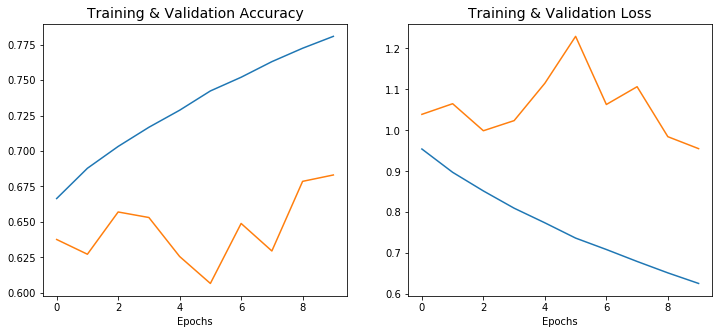

In [24]:
# Storing the training and validation metrics
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))


# Plotting training and validation accuracy/loss
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training & Validation Accuracy', size=14)
plt.xlabel('Epochs')

plt.subplot(122)
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training & Validation Loss', size=14)
plt.xlabel('Epochs')

plt.show()

## Second Model

We'll add some Dropout layers to deal with the overfitting we're experiencing, but will keep the same overall architecture.

In [25]:
# Model instantiation
model = Sequential()
model.add(Conv2D(16, kernel_size=(3,3), 
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.15))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.15))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 64)          18496     
___________________________

In [26]:
# Compile and train the initial model. 

model.compile(loss=categorical_crossentropy, 
              optimizer=RMSprop(),
              metrics=['acc'])

history = model.fit(train_img,
                    train_label,
                    batch_size=64,
                    epochs=10, 
                    verbose=1,
                    validation_data=(test_img, test_label))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 18s 363us/step - loss: 1.8740 - acc: 0.3046 - val_loss: 1.5967 - val_acc: 0.4179
Epoch 2/10
50000/50000 [==============================] - 19s 388us/step - loss: 1.5522 - acc: 0.4360 - val_loss: 1.3641 - val_acc: 0.5174
Epoch 3/10
50000/50000 [==============================] - 17s 340us/step - loss: 1.3999 - acc: 0.5008 - val_loss: 1.2919 - val_acc: 0.5360
Epoch 4/10
50000/50000 [==============================] - 17s 347us/step - loss: 1.2987 - acc: 0.5411 - val_loss: 1.4560 - val_acc: 0.4682
Epoch 5/10
50000/50000 [==============================] - 20s 399us/step - loss: 1.2320 - acc: 0.5686 - val_loss: 1.2494 - val_acc: 0.5655
Epoch 6/10
50000/50000 [==============================] - 18s 367us/step - loss: 1.1785 - acc: 0.5869 - val_loss: 1.1841 - val_acc: 0.5878
Epoch 7/10
50000/50000 [==============================] - 19s 370us/step - loss: 1.1330 - acc: 0.6023 - val_loss: 1.

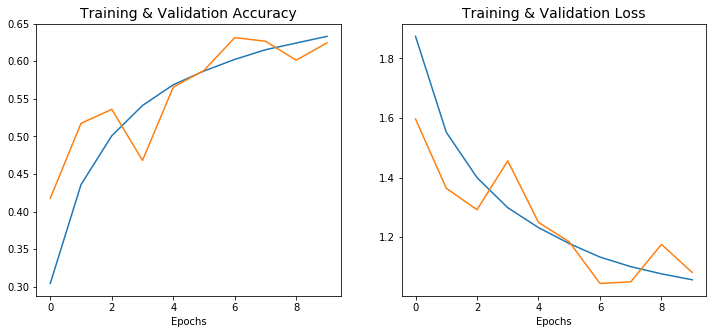

In [27]:
# Storing the training and validation metrics
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))


# Plotting training and validation accuracy/loss
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training & Validation Accuracy', size=14)
plt.xlabel('Epochs')

plt.subplot(122)
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training & Validation Loss', size=14)
plt.xlabel('Epochs')

plt.show()

We've fixed the overfit issue, however we've decreased our model accuracy.  Let's add a few more Covolutional layers and increase the size of the last Dense layer.  And seeing as how we have stopped the model early, we will increase the number of epochs.

## Model 3

In [29]:
# Model instantiation
model = Sequential()
model.add(Conv2D(16, kernel_size=(3,3), 
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.15))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.15))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 30, 30, 16)        448       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 64)          36928     
__________

In [30]:
# Compile and train the initial model. 

model.compile(loss=categorical_crossentropy, 
              optimizer=RMSprop(),
              metrics=['acc'])

history = model.fit(train_img,
                    train_label,
                    batch_size=64,
                    epochs=10, 
                    verbose=1,
                    validation_data=(test_img, test_label))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 65s 1ms/step - loss: 1.7145 - acc: 0.3679 - val_loss: 1.4089 - val_acc: 0.4792
Epoch 2/10
50000/50000 [==============================] - 64s 1ms/step - loss: 1.3063 - acc: 0.5308 - val_loss: 1.3720 - val_acc: 0.5355
Epoch 3/10
50000/50000 [==============================] - 62s 1ms/step - loss: 1.1207 - acc: 0.6033 - val_loss: 1.0005 - val_acc: 0.6458
Epoch 4/10
50000/50000 [==============================] - 63s 1ms/step - loss: 0.9953 - acc: 0.6518 - val_loss: 0.9186 - val_acc: 0.6767
Epoch 5/10
50000/50000 [==============================] - 62s 1ms/step - loss: 0.9109 - acc: 0.6829 - val_loss: 0.8635 - val_acc: 0.6988
Epoch 6/10
50000/50000 [==============================] - 63s 1ms/step - loss: 0.8606 - acc: 0.6984 - val_loss: 0.8537 - val_acc: 0.6995
Epoch 7/10
50000/50000 [==============================] - 64s 1ms/step - loss: 0.8102 - acc: 0.7201 - val_loss: 0.8615 - val_acc

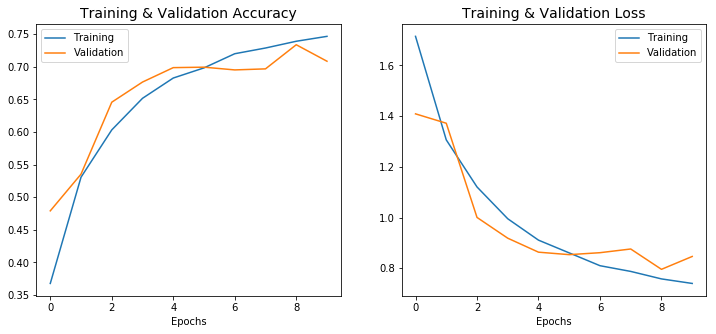

In [34]:
# Storing the training and validation metrics
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))


# Plotting training and validation accuracy/loss
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training & Validation Accuracy', size=14)
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'])

plt.subplot(122)
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training & Validation Loss', size=14)
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'])

plt.show()

That's a better performing model now.  For the next step, we'll increase the epochs (because we forgot to in the last model), increase the initial layer size, and increase the batch size.

## Model 4

In [35]:
# Model instantiation
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), 
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.15))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.15))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 4, 4, 128)         73856     
__________

In [36]:
# Compile and train the initial model. 

model.compile(loss=categorical_crossentropy, 
              optimizer=RMSprop(),
              metrics=['acc'])

history = model.fit(train_img,
                    train_label,
                    batch_size=128,
                    epochs=20, 
                    verbose=1,
                    validation_data=(test_img, test_label))

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 109s 2ms/step - loss: 1.7849 - acc: 0.3553 - val_loss: 1.4827 - val_acc: 0.4661
Epoch 2/20
50000/50000 [==============================] - 103s 2ms/step - loss: 1.3396 - acc: 0.5245 - val_loss: 1.1383 - val_acc: 0.6004
Epoch 3/20
50000/50000 [==============================] - 102s 2ms/step - loss: 1.1314 - acc: 0.6031 - val_loss: 1.0933 - val_acc: 0.6192
Epoch 4/20
50000/50000 [==============================] - 104s 2ms/step - loss: 0.9867 - acc: 0.6541 - val_loss: 0.9631 - val_acc: 0.6732
Epoch 5/20
50000/50000 [==============================] - 103s 2ms/step - loss: 0.8870 - acc: 0.6906 - val_loss: 0.8086 - val_acc: 0.7217
Epoch 6/20
50000/50000 [==============================] - 102s 2ms/step - loss: 0.8041 - acc: 0.7211 - val_loss: 0.8184 - val_acc: 0.7195
Epoch 7/20
50000/50000 [==============================] - 102s 2ms/step - loss: 0.7443 - acc: 0.7428 - val_loss: 0.9443 - 

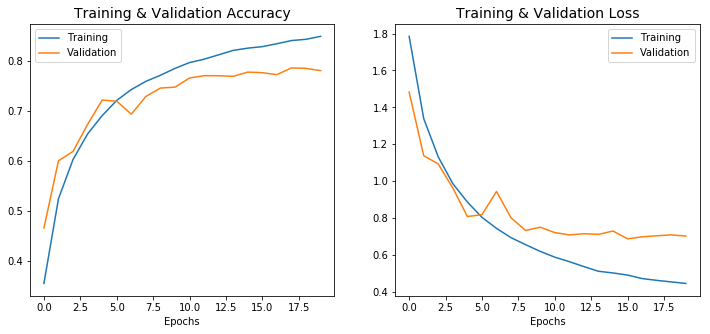

In [37]:
# Storing the training and validation metrics
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))


# Plotting training and validation accuracy/loss
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training & Validation Accuracy', size=14)
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'])

plt.subplot(122)
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training & Validation Loss', size=14)
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'])

plt.show()

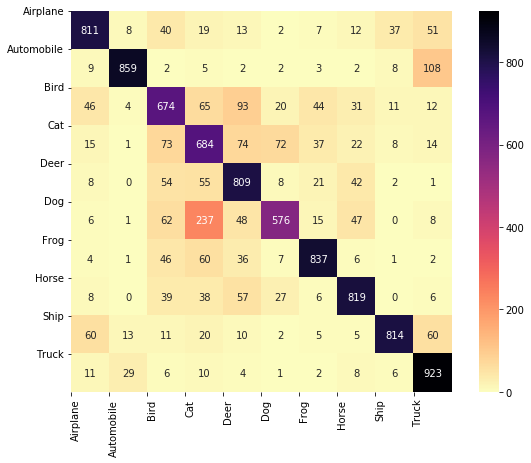

In [75]:
# Generating a confusion matrix

test_label_pred = model.predict(test_img)
matrix = confusion_matrix(test_label.argmax(axis=1), 
                          test_label_pred.argmax(axis=1))


# Plotting confusion matrix

plt.figure(figsize=(10,7))
sns.heatmap(matrix, cmap='magma_r', annot=True, fmt='g', square=True)
plt.yticks([i for i in range(10)], 
           label_names, 
           rotation='horizontal',
           verticalalignment='center')
plt.xticks([i for i in range(10)], 
           label_names, 
           rotation=90, 
           horizontalalignment='left')
plt.show()

This model took significantly longer to train (~30 min), however, we did acheive improved performance.  Note that the model started to overfit around Epoch 10.


## Model 5

For the last model, we'll try adding more Conv2D layers and an additional Dense layer at the end.

In [82]:
# Model instantiation
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu',input_shape=input_shape))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.15))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.15))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 30, 30, 16)        448       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 28, 28, 32)        4640      
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 26, 26, 64)        18496     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 11, 11, 32)        18464     
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 9, 9, 64)          18496     
__________

In [83]:
# Compile and train the initial model. 

model.compile(loss=categorical_crossentropy, 
              optimizer=RMSprop(),
              metrics=['acc'])

history = model.fit(train_img,
                    train_label,
                    batch_size=128,
                    epochs=20, 
                    verbose=1,
                    validation_data=(test_img, test_label))

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 119s 2ms/step - loss: 1.9464 - acc: 0.2811 - val_loss: 1.6949 - val_acc: 0.3857
Epoch 2/20
50000/50000 [==============================] - 115s 2ms/step - loss: 1.5619 - acc: 0.4380 - val_loss: 1.4784 - val_acc: 0.4656
Epoch 3/20
50000/50000 [==============================] - 115s 2ms/step - loss: 1.3536 - acc: 0.5178 - val_loss: 1.2726 - val_acc: 0.5480
Epoch 4/20
50000/50000 [==============================] - 115s 2ms/step - loss: 1.2132 - acc: 0.5735 - val_loss: 1.0969 - val_acc: 0.6101
Epoch 5/20
50000/50000 [==============================] - 115s 2ms/step - loss: 1.1130 - acc: 0.6114 - val_loss: 1.0549 - val_acc: 0.6255
Epoch 6/20
50000/50000 [==============================] - 114s 2ms/step - loss: 1.0258 - acc: 0.6446 - val_loss: 1.0868 - val_acc: 0.6098
Epoch 7/20
50000/50000 [==============================] - 150s 3ms/step - loss: 0.9483 - acc: 0.6712 - val_loss: 0.9059 - 

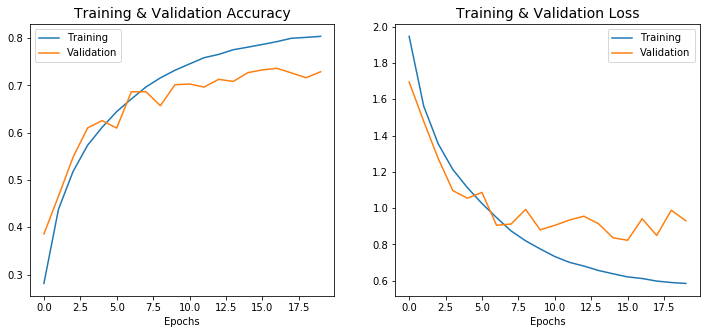

In [84]:
# Storing the training and validation metrics
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))


# Plotting training and validation accuracy/loss
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training & Validation Accuracy', size=14)
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'])

plt.subplot(122)
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training & Validation Loss', size=14)
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'])

plt.show()

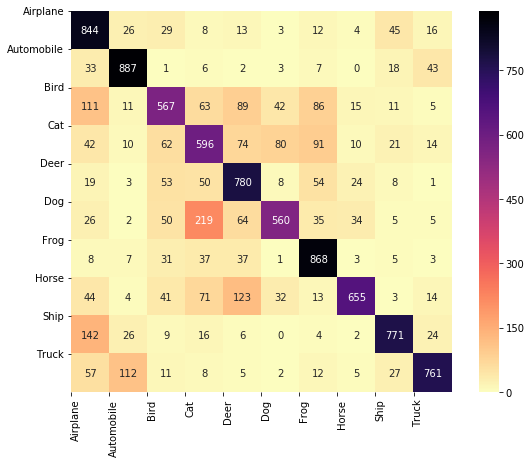

In [85]:
# Generating a confusion matrix

test_label_pred = model.predict(test_img)
matrix = confusion_matrix(test_label.argmax(axis=1), 
                          test_label_pred.argmax(axis=1))


# Plotting confusion matrix

plt.figure(figsize=(10,7))
sns.heatmap(matrix, cmap='magma_r', annot=True, fmt='g', square=True)
plt.yticks([i for i in range(10)], 
           label_names, 
           rotation='horizontal',
           verticalalignment='center')
plt.xticks([i for i in range(10)], 
           label_names, 
           rotation=90, 
           horizontalalignment='left')
plt.show()

This model did not perform as well as Model 4.  It also took ~40 minutes to train.